# Exercici 2.11. Smart City Traffic Intelligence

Carrega els CSV i revisa les dades

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

readings = pd.read_csv('./data/traffic_readings.csv')
sensors = pd.read_csv('./data/traffic_sensors.csv')
weather = pd.read_csv('./data/traffic_weather.csv')

print('readings', readings.shape)
display(readings.head())
print('\nsensors', sensors.shape)
display(sensors.head())
print('\nweather', weather.shape)
display(weather.head())

readings (10000, 6)


,reading_id,sensor_id,timestamp,cars,trucks,avg_speed
0,1,49,2024-10-08 11:50:00,21,5,45.66
1,2,44,2024-09-10 04:01:00,19,5,37.61
2,3,38,2024-12-09 18:19:00,15,5,30.93
3,4,15,2024-02-09 12:58:00,24,5,40.64
4,5,19,2024-12-01 07:18:00,22,3,37.34



sensors (50, 3)


,sensor_id,location,district
0,1,Intersection 1,West
1,2,Intersection 2,West
2,3,Intersection 3,East
3,4,Intersection 4,North
4,5,Intersection 5,North



weather (365, 4)


,date,temperature,rain_mm,wind_kmh
0,2024-01-01,13.46,0.50,23.68
1,2024-01-02,8.42,0.15,1.27
2,2024-01-03,14.48,2.19,0.16
3,2024-01-04,13.48,4.91,8.51
4,2024-01-05,40.55,3.08,29.46


Uneix trànsit + meteorologia

Convertir timestamps

Afegir columna date a readings

Merge per date

In [9]:
readings['timestamp'] = pd.to_datetime(readings['timestamp'])
weather['date'] = pd.to_datetime(weather['date']).dt.date

readings['date'] = readings['timestamp'].dt.date
readings['hour'] = readings['timestamp'].dt.hour
readings['total_vehicles'] = readings['cars'] + readings['trucks']

traffic_weather = readings.merge(sensors, on='sensor_id', how='left').merge(weather, on='date', how='left')
print(traffic_weather[['sensor_id', 'district', 'timestamp', 'total_vehicles', 'rain_mm']].head())
print(traffic_weather.shape)

   sensor_id district           timestamp  total_vehicles  rain_mm
0         49     West 2024-10-08 11:50:00              26     1.52
1         44   Centre 2024-09-10 04:01:00              24     2.61
2         38     East 2024-12-09 18:19:00              20     2.33
3         15     West 2024-02-09 12:58:00              29     4.16
4         19     East 2024-12-01 07:18:00              25     0.65
(10000, 14)


Gràfic 1 — Boxplot de velocitat per districte

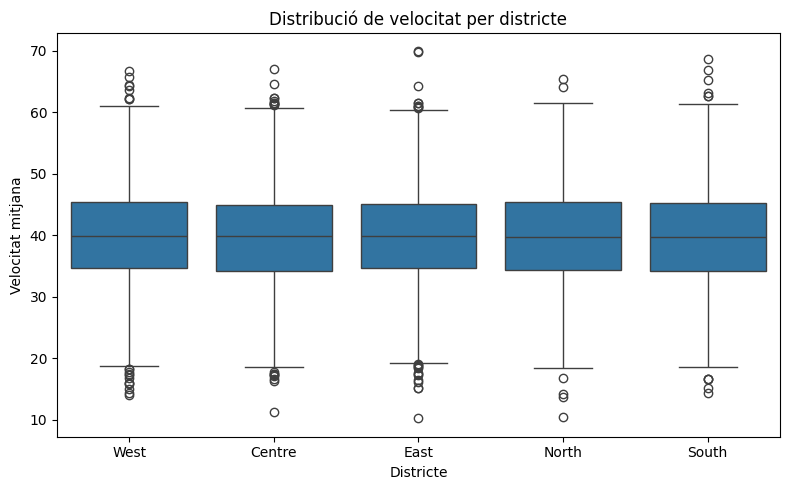

In [10]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=traffic_weather, x='district', y='avg_speed')
plt.title('Distribució de velocitat per districte')
plt.xlabel('Districte')
plt.ylabel('Velocitat mitjana')
plt.tight_layout()

Gràfic 2 — Trajectòria temporal

Mitjana de vehicles per hora del dia

Lineplot de 24h

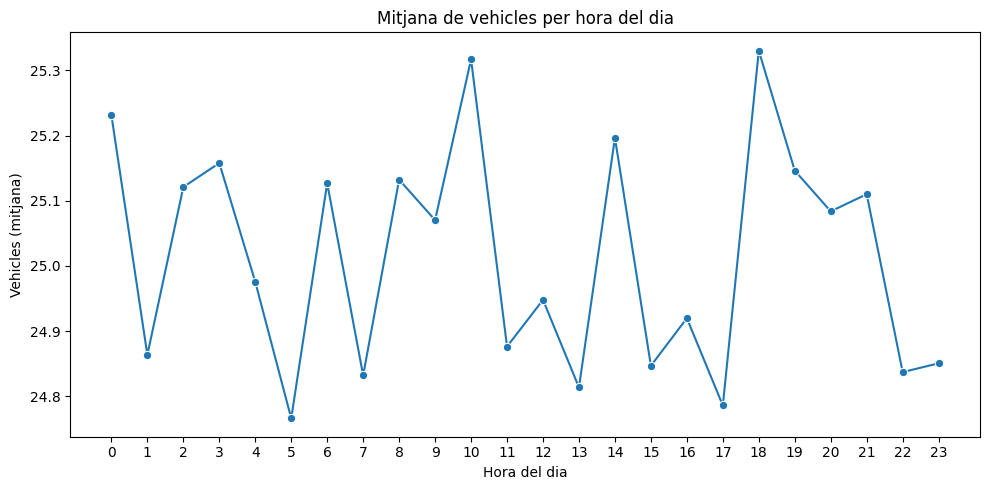

In [11]:
hourly = traffic_weather.groupby('hour')['total_vehicles'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly, x='hour', y='total_vehicles', marker='o')
plt.title('Mitjana de vehicles per hora del dia')
plt.xlabel('Hora del dia')
plt.ylabel('Vehicles (mitjana)')
plt.xticks(range(0, 24))
plt.tight_layout()

Gràfic 3 — Regressió pluja vs trànsit

Relació entre pluja i nombre de vehicles

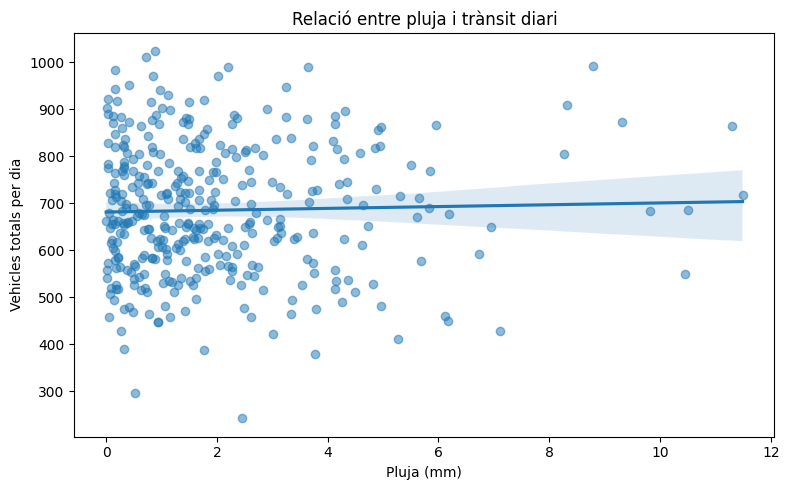

In [12]:
daily_traffic = traffic_weather.groupby('date')['total_vehicles'].sum().reset_index()
daily = daily_traffic.merge(weather, on='date', how='left')
plt.figure(figsize=(8, 5))
sns.regplot(data=daily, x='rain_mm', y='total_vehicles', scatter_kws={'alpha': 0.5})
plt.title('Relació entre pluja i trànsit diari')
plt.xlabel('Pluja (mm)')
plt.ylabel('Vehicles totals per dia')
plt.tight_layout()

Anàlisi d’anomalies

Detectar dies amb trànsit total 2 desviacions estàndard per damunt o per davall

In [13]:
mean_traffic = daily['total_vehicles'].mean()
std_traffic = daily['total_vehicles'].std()
upper = mean_traffic + 2 * std_traffic
lower = mean_traffic - 2 * std_traffic

anomalies = daily[(daily['total_vehicles'] > upper) | (daily['total_vehicles'] < lower)]
print(f"Mitjana: {mean_traffic:.1f} | Desviació: {std_traffic:.1f} | Llindars: [{lower:.1f}, {upper:.1f}]")
print('Dies anòmals (vehicles i pluja):')
display(anomalies[['date', 'total_vehicles', 'rain_mm']].sort_values('total_vehicles', ascending=False))

Mitjana: 685.3 | Desviació: 138.6 | Llindars: [408.2, 962.4]
Dies anòmals (vehicles i pluja):


,date,total_vehicles,rain_mm
112,2024-04-22,1024,0.88
99,2024-04-09,1011,0.72
188,2024-07-07,992,8.79
139,2024-05-19,991,2.19
353,2024-12-19,991,3.64
166,2024-06-15,984,0.15
60,2024-03-01,972,0.84
26,2024-01-27,971,2.02
278,2024-10-05,390,0.32
129,2024-05-09,387,1.76


Mapeig de congestió

Heatmap: district × hora

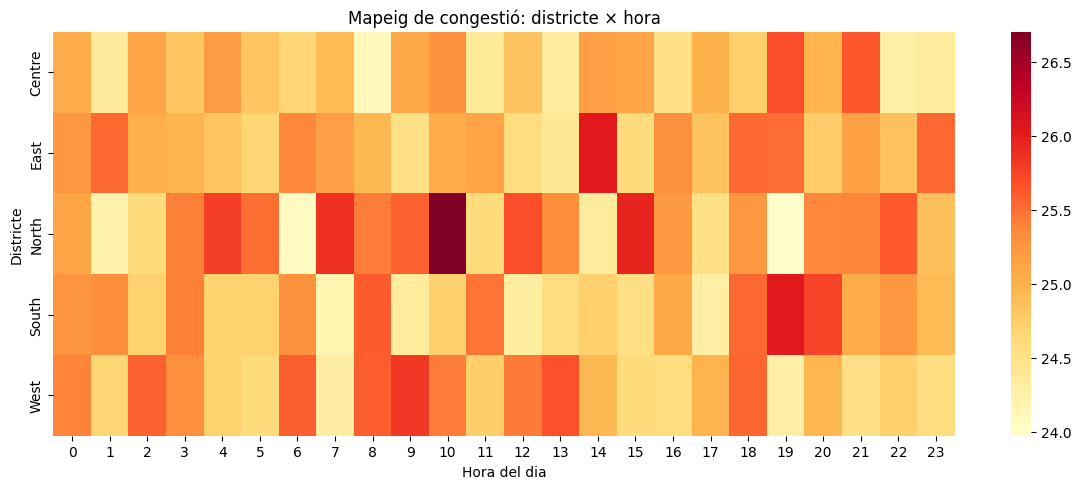

In [14]:
heat = traffic_weather.pivot_table(index='district', columns='hour', values='total_vehicles', aggfunc='mean')
plt.figure(figsize=(12, 5))
sns.heatmap(heat, cmap='YlOrRd')
plt.title('Mapeig de congestió: districte × hora')
plt.xlabel('Hora del dia')
plt.ylabel('Districte')
plt.tight_layout()